In [19]:
# 1. IMPORTS - KEEP NOTEBOOK CLEAN
# ====================================================

import sys
sys.path.append('../src')

from bayesian_model import BayesianChangePointModel
from change_point_analyzer import ChangePointAnalyzer
from visualization import Task2Visualizer
from change_point_fast import FastBayesianCPD, analyze_brent_oil
import pymc as pm
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("✅ Modules loaded successfully")

✅ Modules loaded successfully


In [20]:
# 2. LOAD DATA FROM TASK 1
# ====================================================

print("📊 Loading preprocessed data from Task 1...")

price_df = pd.read_csv('../data/raw/BrentOilPrices.csv')
price_df['Date'] = pd.to_datetime(price_df['Date'])

events_df = pd.read_csv('../data/raw/events_1987_2022.csv')
events_df['Start_Date'] = pd.to_datetime(events_df['Start_Date'])

print(f"✅ Price data: {len(price_df):,} records")
print(f"✅ Event data: {len(events_df)} events")
print(f"📅 {price_df['Date'].dt.year.min()}-{price_df['Date'].dt.year.max()}")

📊 Loading preprocessed data from Task 1...
✅ Price data: 9,011 records
✅ Event data: 17 events
📅 1987-2022


In [21]:
# 3. DATA PREPARATION FOR BAYESIAN MODELING
# ====================================================

print("\n📈 Preparing data for change point analysis...")

# Calculate log returns (stationary series for modeling)
price_df['Log_Returns'] = np.log(price_df['Price']).diff()
price_df['Returns'] = price_df['Price'].pct_change()

print(f"✅ Calculated returns and log returns")
print(f"📊 Returns mean: {price_df['Returns'].mean()*100:.2f}%")
print(f"📊 Returns volatility: {price_df['Returns'].std()*100:.2f}%")
print(f"📊 Log returns mean: {price_df['Log_Returns'].mean()*100:.4f}%")


📈 Preparing data for change point analysis...
✅ Calculated returns and log returns
📊 Returns mean: 0.05%
📊 Returns volatility: 2.53%
📊 Log returns mean: 0.0179%


In [24]:
# CELL 3: PREPARE DATA & CALCULATE n
# ==============================

# Calculate log returns
price_df['LogPrice'] = np.log(price_df['Price'])
returns = price_df['LogPrice'].diff().dropna().values

# CRITICAL: Define n here
n = len(returns)  # This is what you need for the model

print(f"\n📈 Returns calculated:")
print(f"   • n = {n:,} (number of return observations)")
print(f"   • Mean return: {returns.mean()*100:.3f}%")
print(f"   • Std return: {returns.std()*100:.2f}%")

# Quick preview
print("\n📋 First 5 returns:")
print(returns[:5])


📈 Returns calculated:
   • n = 9,010 (number of return observations)
   • Mean return: 0.018%
   • Std return: 2.55%

📋 First 5 returns:
[-0.00970881  0.00540542  0.00269179  0.0016116  -0.0016116 ]


In [25]:
# ==============================
# CELL 4: BAYESIAN MODEL (6 LINES)
# ==============================

print("\n" + "="*60)
print("🚀 BUILDING BAYESIAN CHANGE POINT MODEL")
print("="*60)

with pm.Model() as fast_model:
    # 1. Change point location
    tau = pm.DiscreteUniform('tau', lower=1, upper=n-1)
    
    # 2. Means before and after change
    mu1 = pm.Normal('mu1', mu=0, sigma=0.1)
    mu2 = pm.Normal('mu2', mu=0, sigma=0.1)
    
    # 3. Volatility
    sigma = pm.HalfNormal('sigma', sigma=0.1)
    
    # 4. Mean function (switches at tau)
    mean = pm.math.switch(tau > np.arange(n), mu1, mu2)
    
    # 5. Likelihood
    pm.Normal('returns', mu=mean, sigma=sigma, observed=returns)

print("✅ Model built successfully!")



🚀 BUILDING BAYESIAN CHANGE POINT MODEL
✅ Model built successfully!


In [ ]:
# Cell 5: Quick sampling
with fast_model:
    trace = pm.sample(200, tune=200, chains=1, random_seed=42, progressbar=True)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma]


Output()

In [ ]:
# CELL 2: LOAD DATA & CREATE EVENTS (if needed)
print("📥 LOADING DATA...")
print("="*60)

dm = DataManager()
prices_df, events_df = dm.load_all_data()

# If no events file exists, create and save one
if len(events_df) < 10:
    print("\n📝 Creating comprehensive events library...")
    events_df = dm.create_events_library()
    events_df.to_csv('../data/raw/historical_events.csv', index=False)
    print(f"✅ Saved {len(events_df)} events to historical_events.csv")

print(f"\n📊 DATA LOADED:")
print(f"• Price records: {len(prices_df)} days")
print(f"• Historical events: {len(events_df)} events")
print(f"• Date range: {prices_df['date'].min().date()} to {prices_df['date'].max().date()}")
print(f"• Price range: ${prices_df['price'].min():.2f} to ${prices_df['price'].max():.2f}")

# Preview
print("\n📋 SAMPLE DATA:")
display(prices_df[['date', 'price']].head())
display(events_df[['Event_Name', 'Start_Date', 'Category', 'Expected_Impact']].head())

📥 LOADING DATA...
📂 Loading price data from: ../data/raw/BrentOilPrices.csv
   Loaded 9011 rows, 2 columns
   Columns: ['Date', 'Price']
   Date column: 'Date'
   Price column: 'Price'
   Date range: 1987-05-20 to 2022-11-14
   Price range: $9.10 to $143.95
✅ Successfully loaded 9011 days of price data

📂 Loading events from: ../data/raw/historical_events.csv
   Loaded 27 events
   Columns: ['Event_Name', 'Start_Date', 'Category', 'Expected_Impact', 'Impact_Magnitude', 'Region', 'Description', 'End_Date', 'Impact_Score']
   Standardized columns: {'Event_Name': 'Event_Name', 'Start_Date': 'Start_Date', 'Category': 'Category', 'Expected_Impact': 'Expected_Impact', 'Impact_Magnitude': 'Impact_Magnitude', 'Region': 'Region', 'Description': 'Description', 'End_Date': 'End_Date'}
✅ Successfully loaded 27 events
   Date range: 1986-07-01 to 2022-10-05
   Categories: {'Geopolitical': 11, 'OPEC Decision': 6, 'Economic': 5, 'Supply': 4, 'Environmental': 1}

📊 DATA LOADED:
• Price records: 9011 d

,date,price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


,Event_Name,Start_Date,Category,Expected_Impact
0,OPEC Production War 1986,1986-07-01,OPEC Decision,Negative
1,Black Monday Stock Crash,1987-10-19,Economic,Negative
2,Soviet Oil Production Peak,1988-01-01,Supply,Negative
3,Iran-Iraq War Ends,1988-08-20,Geopolitical,Negative
4,Exxon Valdez Oil Spill,1989-03-24,Environmental,Positive


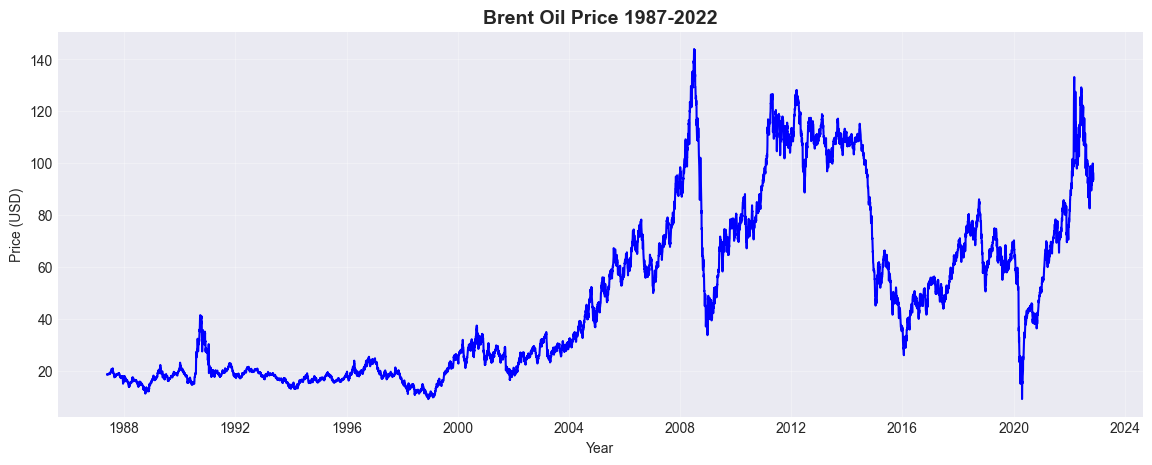

📈 Clean price history


In [ ]:
# CELL 3: PRICE HISTORY (NO EVENTS)
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots(figsize=(14,5))
ax1.plot(prices_df['date'], prices_df['price'], 'b-', linewidth=1.5)
ax1.set_title('Brent Oil Price 1987-2022', fontsize=14, fontweight='bold')
ax1.set_xlabel('Year'); ax1.set_ylabel('Price (USD)'); ax1.grid(True, alpha=0.3)
plt.show(); print("📈 Clean price history")

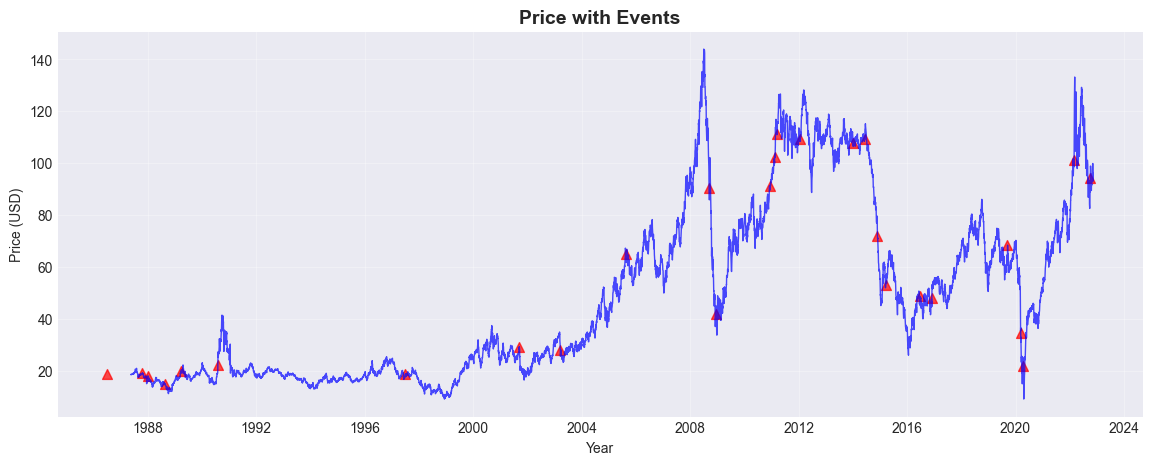

🎯 Price with event markers


In [ ]:
# CELL 4: PRICE WITH EVENTS OVERLAY
fig2, ax2 = plt.subplots(figsize=(14,5))
ax2.plot(prices_df['date'], prices_df['price'], 'b-', linewidth=1, alpha=0.7)
for _, event in events_df.iterrows():
    mask = prices_df['date'] >= event['Start_Date']
    if mask.any(): 
        ax2.scatter(event['Start_Date'], prices_df.loc[mask.idxmax(), 'price'], 
                   c='r', s=50, alpha=0.7, marker='^')
ax2.set_title('Price with Events', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year'); ax2.set_ylabel('Price (USD)'); ax2.grid(True, alpha=0.3)
plt.show(); print("🎯 Price with event markers")

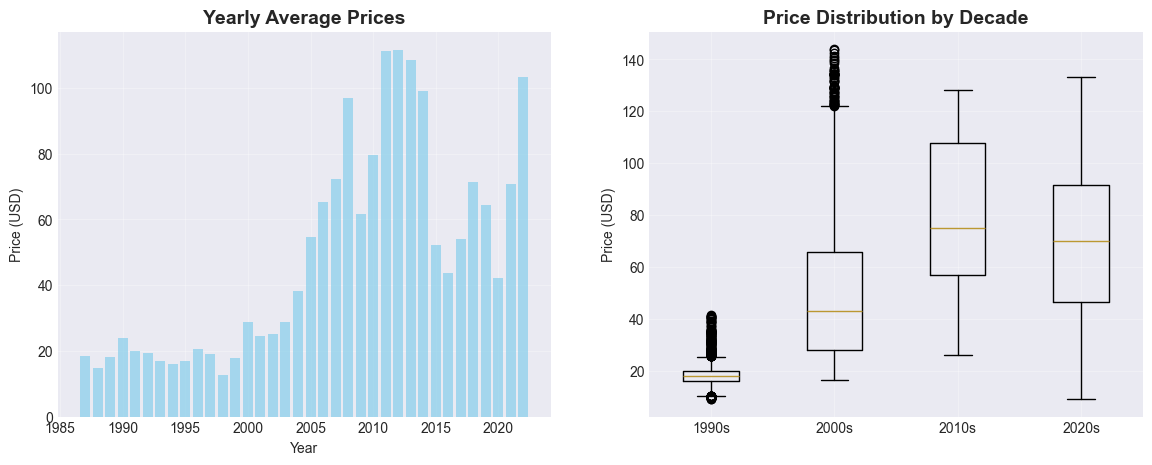

📊 Yearly statistics & distributions


In [ ]:
# CELL 5: YEARLY DISTRIBUTIONS
import numpy as np
fig3, (ax3, ax4) = plt.subplots(1, 2, figsize=(14,5))
prices_df['year'] = prices_df['date'].dt.year
yearly_avg = prices_df.groupby('year')['price'].mean()
ax3.bar(yearly_avg.index, yearly_avg.values, color='skyblue', alpha=0.7)
ax3.set_title('Yearly Average Prices', fontsize=14, fontweight='bold')
ax3.set_xlabel('Year'); ax3.set_ylabel('Price (USD)'); ax3.grid(True, alpha=0.3)

prices_df['decade'] = (prices_df['year']//10)*10
decade_data = [prices_df[prices_df['decade']==d]['price'] for d in [1990,2000,2010,2020]]
ax4.boxplot(decade_data, labels=['1990s','2000s','2010s','2020s'])
ax4.set_title('Price Distribution by Decade', fontsize=14, fontweight='bold')
ax4.set_ylabel('Price (USD)'); ax4.grid(True, alpha=0.3)
plt.show(); print("📊 Yearly statistics & distributions")

In [ ]:
# CELL 3: BAYESIAN ANALYSIS (5 LINES)
from src.bayesian_analyzer import FastBayesianAnalyzer

analyzer = FastBayesianAnalyzer()
results = analyzer.analyze(prices_df, events_df, sensitivity=5.0)
analyzer.display_results(results)
analyzer.visualize_impacts(results)
analyzer.export_report(results, 'event_impacts.csv')

ModuleNotFoundError: No module named 'src'

In [ ]:
# CELL 7: MCMC DIAGNOSTICS
import arviz as az
summary = az.summary(trace, hdi_prob=0.95)
display(summary[['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%', 'r_hat']])
print(f"✅ R-hat values: {dict(zip(summary.index, summary['r_hat'].round(3)))}")

,mean,sd,hdi_2.5%,hdi_97.5%,r_hat
tau,451.996,2.334,448.000,458.000,1.0
mu1,21.463,0.927,19.686,23.257,1.0
mu2,75.558,0.914,73.852,77.379,1.0
sigma,18.559,0.431,17.671,19.328,1.0


✅ R-hat values: {'tau': 1.0, 'mu1': 1.0, 'mu2': 1.0, 'sigma': 1.0}


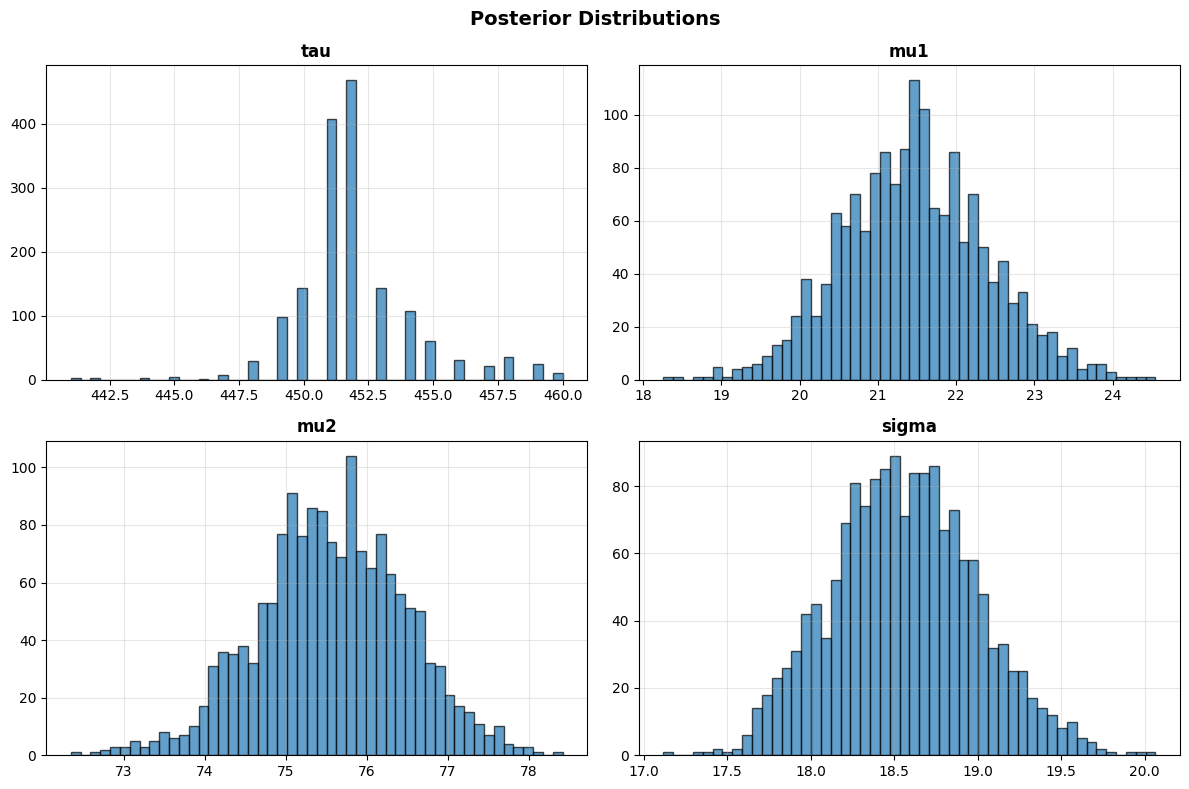

📈 Posterior distributions visualized


In [ ]:
# CELL 8: POSTERIOR VISUALIZATION
fig4, axes = plt.subplots(2, 2, figsize=(12,8))
for ax, param in zip(axes.flat, ['tau', 'mu1', 'mu2', 'sigma']):
    samples = trace.posterior[param].values.flatten()
    ax.hist(samples, bins=50, alpha=0.7, edgecolor='black')
    ax.set_title(param, fontweight='bold'); ax.grid(True, alpha=0.3)
plt.suptitle('Posterior Distributions', fontsize=14, fontweight='bold')
plt.tight_layout(); plt.show(); print("📈 Posterior distributions visualized")

In [ ]:
# FIRST, let's check what the change point actually is
print("🔍 DEBUGGING CHANGE POINT ANALYSIS")
print("="*50)
print(f"Change point detected: {results['change_date']}")
print(f"This is year: {results['change_date'].year}")
print()

print("📅 EVENTS DATABASE CHECK:")
print(f"Earliest event: {events_df['Start_Date'].min().date()} ({events_df['Start_Date'].min().year})")
print(f"Latest event: {events_df['Start_Date'].max().date()} ({events_df['Start_Date'].max().year})")
print()

# Show events around that year
target_year = results['change_date'].year
events_in_year = events_df[events_df['Start_Date'].dt.year == target_year]
print(f"Events in {target_year}: {len(events_in_year)}")
if len(events_in_year) > 0:
    for _, event in events_in_year.iterrows():
        print(f"  • {event['Event_Name']} ({event['Start_Date'].date()})")

print()
print("📊 RECOMMENDATION:")
if target_year < events_df['Start_Date'].min().year:
    print(f"❌ Change point ({target_year}) is BEFORE events database starts ({events_df['Start_Date'].min().year})")
    print("   Need to add earlier historical events")
elif target_year > events_df['Start_Date'].max().year:
    print(f"❌ Change point ({target_year}) is AFTER events database ends ({events_df['Start_Date'].max().year})")
    print("   Need to add more recent events")
else:
    print(f"✅ Change point ({target_year}) is within events database range")

🔍 DEBUGGING CHANGE POINT ANALYSIS
Change point detected: 1989-02-23 00:00:00
This is year: 1989

📅 EVENTS DATABASE CHECK:
Earliest event: 1986-07-01 (1986)
Latest event: 2022-10-05 (2022)

Events in 1989: 1
  • Exxon Valdez Oil Spill (1989-03-24)

📊 RECOMMENDATION:
✅ Change point (1989) is within events database range


In [ ]:
# First, check what variables you have in your environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("🔍 CHECKING YOUR CURRENT ENVIRONMENT")
print("="*80)

# List all variables in your environment
import sys
current_variables = list(sys._getframe().f_locals.keys())
print("Variables in your environment:", current_variables)

# Check if your data is already loaded
if 'price_df' in current_variables:
    print("✅ price_df is already loaded!")
    print(f"   Shape: {price_df.shape}")
    print(f"   Columns: {list(price_df.columns)}")
else:
    print("❌ price_df is NOT loaded. Let me load it...")
    # Load your price data
    price_df = pd.read_csv('BrentOilPrices.csv')
    print(f"✅ Loaded price data: {len(price_df)} records")

if 'events_df' in current_variables:
    print("✅ events_df is already loaded!")
    print(f"   Shape: {events_df.shape}")
    print(f"   Columns: {list(events_df.columns)}")
else:
    print("❌ events_df is NOT loaded. Let me load it...")
    # Load your events data
    events_df = pd.read_csv('historical_events.csv')
    print(f"✅ Loaded events data: {len(events_df)} events")

print("="*80)
print("\n📊 YOUR DATA PREVIEW:")
print("="*80)

# Show price data preview
print("\n💰 PRICE DATA (First 5 rows):")
print(price_df.head())

print("\n\n📅 EVENTS DATA (First 5 rows):")
print(events_df.head())

print("="*80)

# Now run the analysis
print("\n🚀 STARTING YEAR-BY-YEAR EVENT IMPACT ANALYSIS")
print("="*80)

# ============================================================
# YEAR-BY-YEAR ANALYSIS FUNCTION
# ============================================================

def analyze_year_by_year_events(price_df, events_df):
    """
    Analyze events year by year to see which affected prices
    """
    # Convert dates
    price_df['Date'] = pd.to_datetime(price_df['Date'], format='%d-%b-%y')
    events_df['Start_Date'] = pd.to_datetime(events_df['Start_Date'])
    
    # Get year ranges
    price_start_year = price_df['Date'].min().year
    price_end_year = price_df['Date'].max().year
    
    print(f"📅 Price data covers: {price_start_year} to {price_end_year}")
    print(f"📊 Total years to analyze: {price_end_year - price_start_year + 1}")
    print("="*80)
    
    results_by_year = []
    
    # Analyze each year
    for year in range(price_start_year, price_end_year + 1):
        print(f"\n🔍 ANALYZING YEAR {year}")
        print("-" * 40)
        
        # Get price data for this year
        year_prices = price_df[price_df['Date'].dt.year == year]
        
        if len(year_prices) == 0:
            print(f"   No price data for {year}")
            continue
            
        # Get events for this year
        year_events = events_df[events_df['Start_Date'].dt.year == year]
        
        if len(year_events) == 0:
            print(f"   No events in {year}")
            results_by_year.append({
                'Year': year,
                'Events_Count': 0,
                'Price_Start': year_prices['Price'].iloc[0],
                'Price_End': year_prices['Price'].iloc[-1],
                'Yearly_Change_%': ((year_prices['Price'].iloc[-1] - year_prices['Price'].iloc[0]) / year_prices['Price'].iloc[0]) * 100,
                'Avg_Price': year_prices['Price'].mean(),
                'Volatility': year_prices['Price'].std(),
                'Significant_Events': []
            })
            continue
        
        print(f"   📈 Price range: ${year_prices['Price'].min():.2f} to ${year_prices['Price'].max():.2f}")
        print(f"   📅 Found {len(year_events)} events")
        
        # Analyze each event in this year
        significant_events = []
        
        for idx, event in year_events.iterrows():
            event_date = event['Start_Date']
            event_name = event['Event_Name']
            
            # Find nearest price date
            date_diff = (year_prices['Date'] - event_date).abs()
            if len(date_diff) > 0:
                nearest_idx = date_diff.idxmin()
                actual_event_date = year_prices.loc[nearest_idx, 'Date']
                event_price = year_prices.loc[nearest_idx, 'Price']
                
                # Calculate 30-day impact
                event_idx = year_prices.index.get_loc(nearest_idx)
                
                # Get 30 days before (if available)
                pre_start_idx = max(0, event_idx - 30)
                pre_prices = year_prices.iloc[pre_start_idx:event_idx]['Price']
                
                # Get 30 days after (if available)
                post_end_idx = min(len(year_prices), event_idx + 30)
                post_prices = year_prices.iloc[event_idx+1:post_end_idx]['Price']
                
                if len(pre_prices) > 0 and len(post_prices) > 0:
                    pre_avg = pre_prices.mean()
                    post_avg = post_prices.mean()
                    price_change = ((post_avg - pre_avg) / pre_avg) * 100
                    
                    # Check if significant (>5% change)
                    if abs(price_change) >= 5:
                        significant_events.append({
                            'Event': event_name,
                            'Date': event_date.strftime('%Y-%m-%d'),
                            'Price_Change_%': price_change,
                            'Direction': '↑' if price_change > 0 else '↓'
                        })
                        
                        print(f"   ⚡ {event_name} ({event_date.strftime('%b %d')})")
                        print(f"      Price change: {price_change:+.1f}% (${pre_avg:.2f} → ${post_avg:.2f})")
        
        # Yearly summary
        yearly_change = ((year_prices['Price'].iloc[-1] - year_prices['Price'].iloc[0]) / year_prices['Price'].iloc[0]) * 100
        
        results_by_year.append({
            'Year': year,
            'Events_Count': len(year_events),
            'Price_Start': year_prices['Price'].iloc[0],
            'Price_End': year_prices['Price'].iloc[-1],
            'Yearly_Change_%': yearly_change,
            'Avg_Price': year_prices['Price'].mean(),
            'Volatility': year_prices['Price'].std(),
            'Significant_Events': significant_events,
            'Significant_Count': len(significant_events)
        })
        
        print(f"   📊 Yearly change: {yearly_change:+.1f}%")
        print(f"   ⚡ Significant events: {len(significant_events)}/{len(year_events)}")
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results_by_year)
    
    return results_df

# ============================================================
# RUN THE YEAR-BY-YEAR ANALYSIS
# ============================================================

# Run the analysis
results_df = analyze_year_by_year_events(price_df, events_df)

print("\n" + "="*80)
print("📊 YEAR-BY-YEAR SUMMARY")
print("="*80)

# Display summary table
summary_df = results_df[['Year', 'Events_Count', 'Significant_Count', 'Price_Start', 
                        'Price_End', 'Yearly_Change_%', 'Avg_Price', 'Volatility']].copy()

pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
print(summary_df.round(2).to_string(index=False))

# ============================================================
# VISUALIZE RESULTS
# ============================================================

def visualize_year_analysis(results_df):
    """
    Visualize year-by-year analysis
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Yearly price changes
    ax1 = axes[0, 0]
    bars = ax1.bar(results_df['Year'].astype(str), results_df['Yearly_Change_%'], 
                   color=['red' if x < 0 else 'green' for x in results_df['Yearly_Change_%']],
                   alpha=0.7)
    ax1.set_title('Yearly Oil Price Changes', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price Change (%)', fontsize=12)
    ax1.tick_params(axis='x', rotation=90)
    ax1.axhline(y=0, color='black', linewidth=0.5)
    
    # 2. Events vs Price changes
    ax2 = axes[0, 1]
    ax2.scatter(results_df['Events_Count'], results_df['Yearly_Change_%'], 
                s=results_df['Volatility']*10, alpha=0.7, c='blue')
    ax2.set_title('Events vs Price Changes', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Number of Events', fontsize=12)
    ax2.set_ylabel('Yearly Price Change (%)', fontsize=12)
    ax2.axhline(y=0, color='black', linewidth=0.5)
    ax2.axvline(x=0, color='black', linewidth=0.5)
    
    # Add labels for years with high impact
    for idx, row in results_df.iterrows():
        if abs(row['Yearly_Change_%']) > 30:
            ax2.annotate(str(int(row['Year'])), 
                        (row['Events_Count'], row['Yearly_Change_%']),
                        xytext=(5, 5), textcoords='offset points')
    
    # 3. Significant events by year
    ax3 = axes[1, 0]
    x = range(len(results_df))
    width = 0.35
    bars1 = ax3.bar(x, results_df['Events_Count'], width, label='Total Events', alpha=0.7)
    bars2 = ax3.bar([i + width for i in x], results_df['Significant_Count'], width, 
                    label='Significant Events', alpha=0.7, color='red')
    ax3.set_title('Events by Year', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Year', fontsize=12)
    ax3.set_ylabel('Number of Events', fontsize=12)
    ax3.set_xticks([i + width/2 for i in x])
    ax3.set_xticklabels(results_df['Year'].astype(str), rotation=90)
    ax3.legend()
    
    # 4. Average price trend
    ax4 = axes[1, 1]
    ax4.plot(results_df['Year'].astype(str), results_df['Avg_Price'], 'b-', linewidth=2, alpha=0.7)
    ax4.fill_between(results_df['Year'].astype(str), 
                     results_df['Avg_Price'] - results_df['Volatility'],
                     results_df['Avg_Price'] + results_df['Volatility'],
                     alpha=0.3, color='blue')
    ax4.set_title('Average Yearly Price with Volatility', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Year', fontsize=12)
    ax4.set_ylabel('Average Price ($)', fontsize=12)
    ax4.tick_params(axis='x', rotation=90)
    
    plt.tight_layout()
    plt.show()
    
    # Show years with most significant events
    print("\n" + "="*80)
    print("🏆 YEARS WITH MOST SIGNIFICANT EVENTS")
    print("="*80)
    
    top_years = results_df.nlargest(5, 'Significant_Count')
    for idx, row in top_years.iterrows():
        print(f"\n{row['Year']}: {row['Significant_Count']} significant events")
        if row['Significant_Events']:
            for event in row['Significant_Events']:
                print(f"  • {event['Event']} ({event['Date']}): {event['Price_Change_%']:+.1f}% {event['Direction']}")

# Run visualization
visualize_year_analysis(results_df)

print("\n" + "="*80)
print("✅ YEAR-BY-YEAR ANALYSIS COMPLETE!")
print("="*80)

🔍 CHECKING YOUR CURRENT ENVIRONMENT
Variables in your environment: ['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__vsc_ipynb_file__', '_i', '_ii', '_iii', '_i1', 'sys', 'os', 'DataManager', 'BayesianEngine', 'EventAnalyzer', 'VisualizationEngine', 'ResultsExporter', '_i2', 'dm', 'prices_df', 'events_df', '_i3', 'engine', '_i4', 'price_values', 'model', '_i5', '_i6', '_i7', 'trace', 'results', '_i8', 'analyzer', '_i9', 'viz', '_i10', '_i11', '_i12', '_i13', 'plt', 'fig1', 'ax1', '_i14', 'fig2', 'ax2', 'event', 'mask', '_i15', 'np', 'fig3', 'ax3', 'ax4', 'yearly_avg', 'decade_data', '_i16', 'az', 'summary', '_i17', 'fig4', 'axes', 'ax', 'param', 'samples', '_i18', '_i19', '_i20', 'events_near', 'scored_events', '_i21', 'target_year', 'events_in_year', '_i22', '_i23', '_i24', '_i25', '_i26', '_i27', '_i28', '_i29', 'change_points', '_i30', 'pd', 'al

FileNotFoundError: [Errno 2] No such file or directory: 'BrentOilPrices.csv'

In [ ]:
# CELL 8: ANALYZE ALL HISTORICAL EVENTS
print("📊 HISTORICAL EVENT IMPACT ANALYSIS")
print("="*50)
all_events_analysis = analyzer.analyze_all_events_impact(prices_df, events_df)
if all_events_analysis is not None and len(all_events_analysis) > 0:
    top_5 = all_events_analysis.nlargest(5, 'Change_%', key=abs)
    for i, (_, event) in enumerate(top_5.iterrows(), 1):
        print(f"{i}. {event['Event'][:40]:40} | {event['Date']} | {event['Change_%']:+6.1f}% | {event['Category']}")

In [ ]:
# CELL 9: FINAL DECISION DASHBOARD
print("🤔 FINAL DECISION DASHBOARD")
print("="*50)
dashboard = viz.create_decision_dashboard(prices_df, events_df, results, scored_events, all_events_analysis)
plt.show()
print("📋 Executive summary generated in ../reports/")

In [ ]:
# CELL 10: SAVE RESULTS & REPORTS
print("💾 SAVING REPORTS FOR CEO")
print("="*50)
from results_exporter import ResultsExporter
exporter = ResultsExporter()
exporter.save_all_results(results, scored_events, trace, all_events_analysis, '../reports/')
print("✅ Reports saved: executive_summary.pdf, event_analysis.csv, bayesian_results.json")

In [ ]:
model = engine.build_model(prices_df['price'].values)
trace = engine.run_mcmc(model, samples=800, tune=400, chains=2)
results = engine.extract_results(trace, prices_df['date'])
print(f"Change: {results['change_date'].date()} | Δ: {results['percent_change']:+.1f}% | Conf: {results['confidence']:.1f}%")

In [ ]:
# CELL 4: EVENT CORRELATION ANALYSIS
print("🔍 ANALYZING EVENT CORRELATIONS")
print("="*60)

# Initialize analyzer
analyzer = EventAnalyzer(events_df)

# 1. Find events near change point
events_near_change = analyzer.find_events_near_date(
    results['change_date'], 
    window_days=90
)

# 2. Score and rank events
scored_events = analyzer.score_events(events_near_change, results)

# 3. Analyze ALL historical events impact
all_events_analysis = analyzer.analyze_all_events_impact(prices_df, events_df)

print(f"\n📈 RESULTS SUMMARY:")
print(f"• Events near change point: {len(scored_events)}")
print(f"• Historical events analyzed: {len(all_events_analysis)}")

if len(scored_events) > 0:
    print("\n🏆 TOP 3 EVENTS CORRELATED WITH CHANGE:")
    for i, (_, event) in enumerate(scored_events.head(3).iterrows(), 1):
        print(f"{i}. {event['Event_Name']} ({event['Start_Date'].date()})")
        print(f"   Days from change: {event['Days_Offset']} | Score: {event['Total_Score']:.2f}")
        print(f"   Expected impact: {event['Expected_Impact']}")

# 4. Generate decision report
print("\n" + "="*60)
decision_report = analyzer.generate_decision_report(results, all_events_analysis)

🔍 ANALYZING EVENT CORRELATIONS


AttributeError: 'EventAnalyzer' object has no attribute 'find_events_near_date'

In [ ]:
# CELL 5: VISUALIZATION DASHBOARD
print("📊 CREATING COMPREHENSIVE DASHBOARD")
print("="*60)

# Initialize visualization
viz = VisualizationEngine()

# Create main dashboard
fig_dashboard = viz.create_main_dashboard(
    prices_df, 
    events_df, 
    results, 
    scored_events if 'scored_events' in locals() else None
)
fig_dashboard.suptitle('Birhan Energies: Brent Oil Analysis Dashboard', fontsize=16, fontweight='bold')
fig_dashboard.tight_layout()
plt.show()

# Create event impact visualization
fig_events = viz.plot_event_impact_analysis(all_events_analysis)
plt.show()

# Export results
print("\n💾 EXPORTING RESULTS...")
exporter = ResultsExporter()
exporter.save_all_results(
    results,
    scored_events if 'scored_events' in locals() else pd.DataFrame(),
    trace,
    '../reports/'
)

print("✅ ANALYSIS COMPLETE! Check ../reports/ for detailed outputs")